In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
# Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential
from keras.regularizers import l2
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#Visualization
import matplotlib.cm as cm
from sklearn import random_projection
# statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
import datetime

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('bmh')
import statsmodels.api as sm
import matplotlib

In [2]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32',
    'Week': 'int32',
    'Year':'int32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
processed_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'
timeseries_path = r'D:\NOVAIMS_MAA\timeseries\POS_revenue_ts.csv'

In [3]:
df = pd.read_csv(timeseries_path,dtype=dtype_dict,usecols = [1,2,3,4,5])

In [4]:
df.head()

,Year,Month,Week,Point-of-Sale_ID,Total_Sales
0,2016,1,1,1,5036475.0
1,2016,1,1,2,3314519.5
2,2016,1,1,3,4570825.0
3,2016,1,1,4,5683519.0
4,2016,1,1,5,3275205.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043040 entries, 0 to 1043039
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   Year              1043040 non-null  int32   
 1   Month             1043040 non-null  int64   
 2   Week              1043040 non-null  int32   
 3   Point-of-Sale_ID  1043040 non-null  category
 4   Total_Sales       97909 non-null    float32 
dtypes: category(1), float32(1), int32(2), int64(1)
memory usage: 21.9 MB


In [6]:
def getDateRangeFromWeek(x): 
    d = str(x['Year']) + "-W" + str(x['Week'])
    r = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return r

def getDateRangeFromMonth(x): 
    if len(str(x['Month'])) ==1:
        m = "0" + str(x['Month'])
    else:   
        m = x['Month']
    d = str(x['Year']) + "-" +  m + "-" + "01"
    r = datetime.datetime.strptime(d, "%Y-%m-%d")
    return r

def preprocessing(dataframe,product_id, period = "Month"):
    if period == "Month":
        data = dataframe[dataframe['Point-of-Sale_ID'] == product_id]
        data = data.groupby(['Year','Month']).sum()['Total_Sales'].reset_index()
        data['Month'] =  data['Month'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data['TimeSeries'] = data[['Year','Month']].apply(getDateRangeFromMonth,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Month'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.sort_index(inplace=True)
        print("monthly timeseries generated")
        return data
    elif period == "Week":
        data = dataframe[dataframe['Point-of-Sale_ID'] == product_id]
        data = data.groupby(['Year','Week']).sum()['Total_Sales'].reset_index()      
        data['Week'] =  data['Week'].astype('string').apply(lambda x: x if int(x) >=10 else "0"+x)
        data = data[data['Week'] != "53"]
        data['TimeSeries'] = data[['Year','Week']].apply(getDateRangeFromWeek,axis  = 1)
        #drop non-relevant columns
        data.drop(['Year','Week'], axis=1, inplace=True)
        data.set_index('TimeSeries',inplace=True)
        data.dropna(inplace=True)
        data.sort_index(inplace=True)
        print("weekly timeseries generated")
        return data
    else:
        print("Error, chosen period not available")   

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def plot_series(data,figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.title('Total_Sales Timeseries')
    plt.xticks(rotation=45)
    plt.plot(data)      

# plot the forecasts in the context of the original dataset
def plot_forecasts(series,train_df, val_df, forecasts, out):
    plt.figure(figsize=(12,6))
    # plot the entire dataset in blue
    plt.plot(data.loc[train_df.index], label = "Train")
    plt.plot(data.loc[val_df.index], label = "Validation")
    if out == 1:
        lines = pd.Series()
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            lines = lines.append(pd.Series(yaxis[0],index = xaxis))
        plt.plot(lines.index, lines.values, color='red')
    # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
        return lines
	# plot the forecasts in red
    else:
        for i in range(len(forecasts)):
            off_s = len(series) - len(val_df) + i - 1
            off_e = off_s + len(forecasts[i])
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = forecasts[i]
            plt.plot(xaxis, yaxis, color='red')
        # show the plot
        plt.xticks(rotation = 90)
        left, right = plt.xlim()
        plt.xlim(left = (left+right)/2,right=right)
        plt.show()
def gridSearchARIMA(data, seasonal = 12, searchRange = range(0,2)):
    p = q = searchRange
    d = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('...')
    print('Running grid search...')
    arima_grid = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                arima_grid[f'{param}x{param_seasonal}'] = results.aic
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    model = min(arima_grid, key=arima_grid.get)
    print("Model have lowest AIC score:", model)
    print("AIC score:", arima_grid[model])
    return arima_grid

def modelARIMAfit(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12)):
    mod = sm.tsa.statespace.SARIMAX(data,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    #print(results.summary().tables[1])
    return results

def oneStepForecast(results, data,test_len = 0.8):
    test_start = data.iloc[int(len(data)*test_len)].name
    pred = results.get_prediction(start=test_start, dynamic=False)
    pred_ci = pred.conf_int()
    # plot
    ax = data.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 6))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = data[test_start:]['Total_Sales'].values
    rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
    mape = mean_absolute_percentage_error(y_truth,y_forecasted)
    print('RMSE = {}'.format(round(rmse, 2)))
    print('MAPE = {}'.format(round(mape, 4)))
    return rmse, mape

def multiStepForecast(data, order, seasonal_order, test_len = 0.8, steps = 3):
    test_start = data.iloc[int(len(data)*test_len)].name
    test_stop = data.iloc[-steps].name
    oos_prediction = list()
    oos_actual = list()
    print(f"Calculating forecasts with {steps} steps ahead")
    for i,date in enumerate(data[test_start:test_stop].index):
        results = modelARIMAfit(data[:date][:-1], order = order, seasonal_order= seasonal_order)   
        pred_uc = results.get_forecast(steps=steps)
        oos_prediction.append(pred_uc.predicted_mean.values)
        oos_actual.append(data[date:][:steps]['Total_Sales'].values)
    return oos_prediction, oos_actual

def evaluateForecastARIMA(oos_prediction,oos_actual, steps):
    for i in range(steps):
        actual = [row[i] for row in oos_actual]
        predicted = [forecast[i] for forecast in oos_prediction]
        rmse = math.sqrt(mean_squared_error(actual,predicted))
        mape = mean_absolute_percentage_error(actual,predicted)
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAPE: %0.4f' % ((i+1), mape))

def multiStepForecast_future(results,steps):
    pred_uc = results.get_forecast(steps=steps)
    pred_ci = pred_uc.conf_int()
    ax = data.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
    return pred_uc.predicted_mean

In [7]:
# Check for top 10 products
df.groupby('Point-of-Sale_ID').sum()['Total_Sales'].sort_values(ascending = False)[:10]

Point-of-Sale_ID
292    2.370513e+09
92     2.040656e+09
280    1.988541e+09
78     1.947181e+09
272    1.886343e+09
103    1.877135e+09
282    1.874645e+09
383    1.796876e+09
359    1.704394e+09
360    1.640051e+09
Name: Total_Sales, dtype: float32

## Non-Seasonal product

In [23]:
data = preprocessing(df,product_id='1')
# the last 2 months data is "error" so we remove them
data = data.iloc[:-2]

monthly timeseries generated


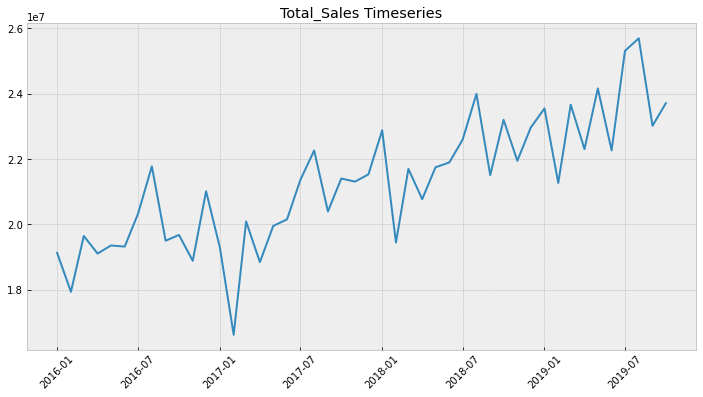

In [25]:
plot_series(data)

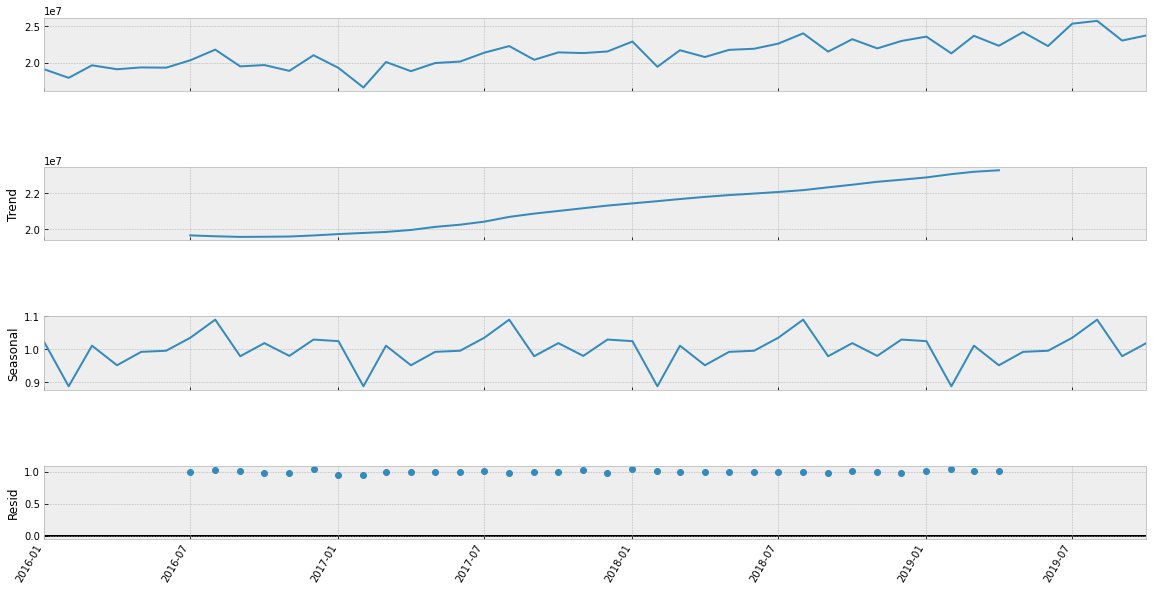

In [26]:
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')
#plot_mpl(fig)

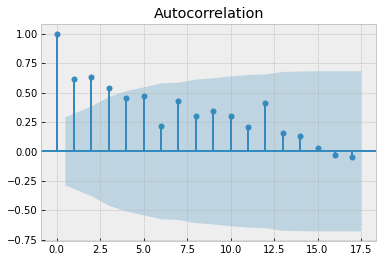

In [28]:
plot_acf(data)
plt.show()

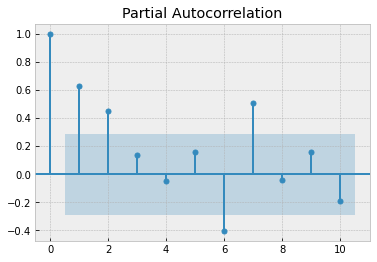

In [29]:
plot_pacf(data, lags=10)
plt.show()

In [27]:
arima_grid = gridSearchARIMA(data, seasonal = 12, searchRange = range(0,2))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
...
Running grid search...
Model have lowest AIC score: (1, 1, 1)x(0, 1, 1, 12)
AIC score: 571.4562158841231


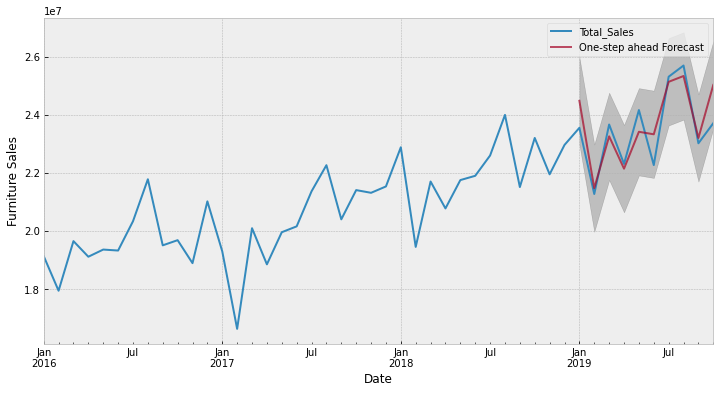

RMSE = 686916.94
MAPE = 0.0237


In [43]:
results = modelARIMAfit(data, order = (0, 1,3), seasonal_order= (0, 1, 1, 12))
rmse, mape = oneStepForecast(results, data)

In [41]:
oos_prediction, oos_actual = multiStepForecast(data, order = (0, 1, 3), seasonal_order= (0, 1, 1, 12), test_len = 0.8, steps = 3)
evaluateForecastARIMA(oos_prediction,oos_actual,steps = 3)

Calculating forecasts with 3 steps ahead
t+1 RMSE: 782189.666383
t+1 MAPE: 0.0293
t+2 RMSE: 696350.816837
t+2 MAPE: 0.0235
t+3 RMSE: 808669.952418
t+3 MAPE: 0.0291


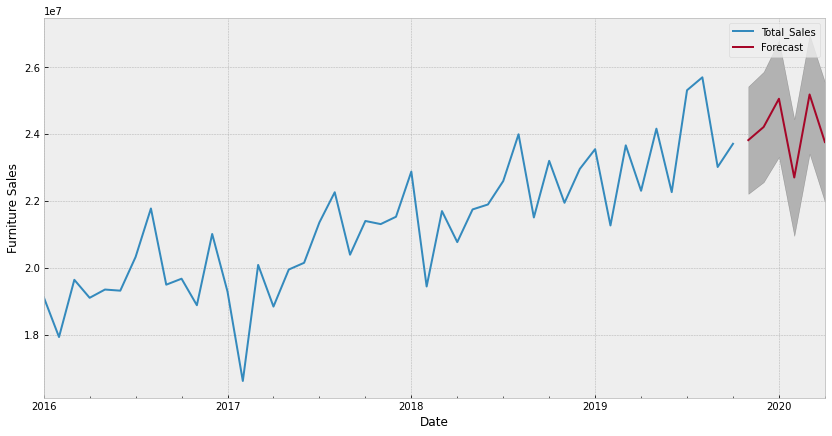

2019-11-01    2.381867e+07
2019-12-01    2.421149e+07
2020-01-01    2.505545e+07
2020-02-01    2.270171e+07
2020-03-01    2.518308e+07
2020-04-01    2.376164e+07
Freq: MS, Name: predicted_mean, dtype: float64

In [34]:
results = modelARIMAfit(data, order = (1, 1, 1), seasonal_order= (0, 1, 1, 12))
multiStepForecast_future(results,steps = 6)

## POS 2

In [10]:
data = preprocessing(df,product_id='19')
data = data.iloc[:-2]

monthly timeseries generated


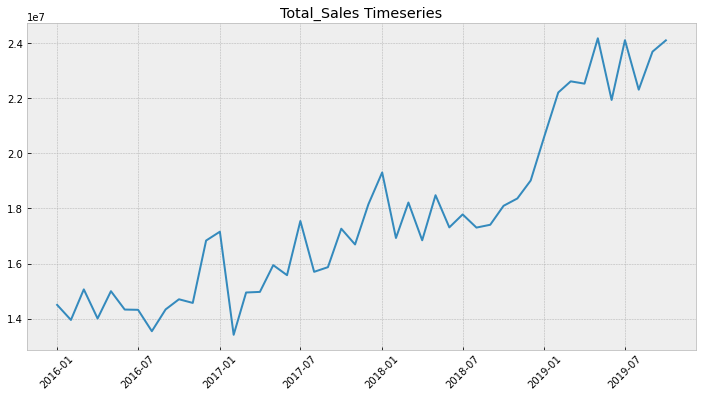

In [11]:
plot_series(data)

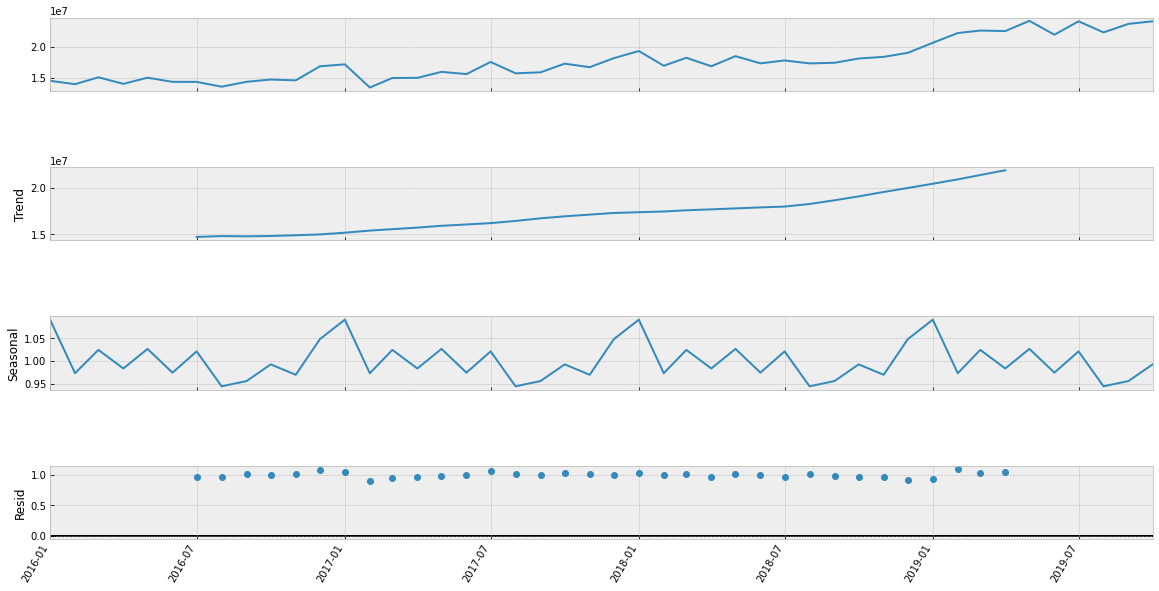

In [12]:
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()
fig.set_size_inches(18, 10)
fig.autofmt_xdate( bottom=0.2, rotation=60, ha='right', which='major')

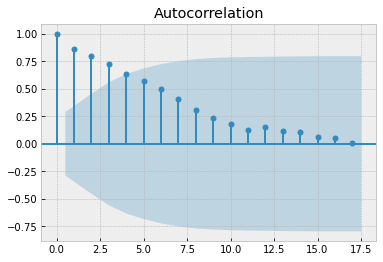

In [13]:
plot_acf(data)
plt.show()

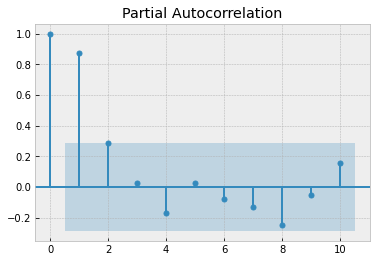

In [14]:
plot_pacf(data, lags=10)
plt.show()

In [24]:
data = preprocessing(df,product_id='19')
data = data.iloc[:-2]
#arima_grid = gridSearchARIMA(data, seasonal = 12, searchRange= range(0,3))

monthly timeseries generated


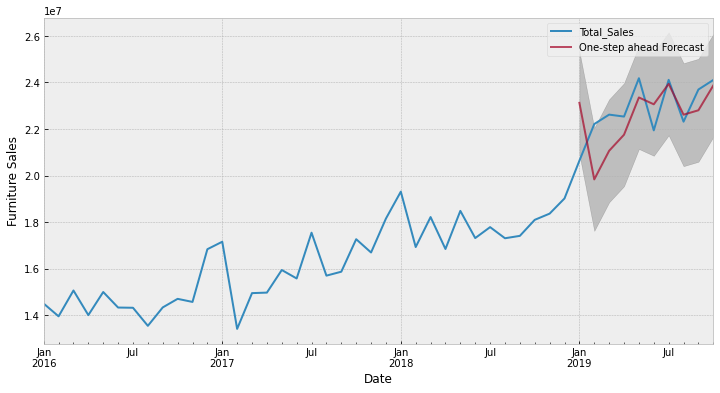

RMSE = 1334018.93
MAPE = 0.0484
Calculating forecasts with 3 steps ahead
t+1 RMSE: 2468038.770933
t+1 MAPE: 0.0858
t+2 RMSE: 1950022.558132
t+2 MAPE: 0.0665
t+3 RMSE: 1738001.200698
t+3 MAPE: 0.0525


In [35]:
order = (2, 1, 0)
seasonal_order= (1, 1, 1, 12)
# 1 step ahead forecast
results = modelARIMAfit(data, order = order, seasonal_order= seasonal_order)
rmse, mape = oneStepForecast(results, data)
# out-of-sample forecast
oos_prediction, oos_actual = multiStepForecast(data, order = order, seasonal_order= seasonal_order, test_len = 0.8, steps = 3)
evaluateForecastARIMA(oos_prediction, oos_actual,steps = 3)

monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated
monthly timeseries generated


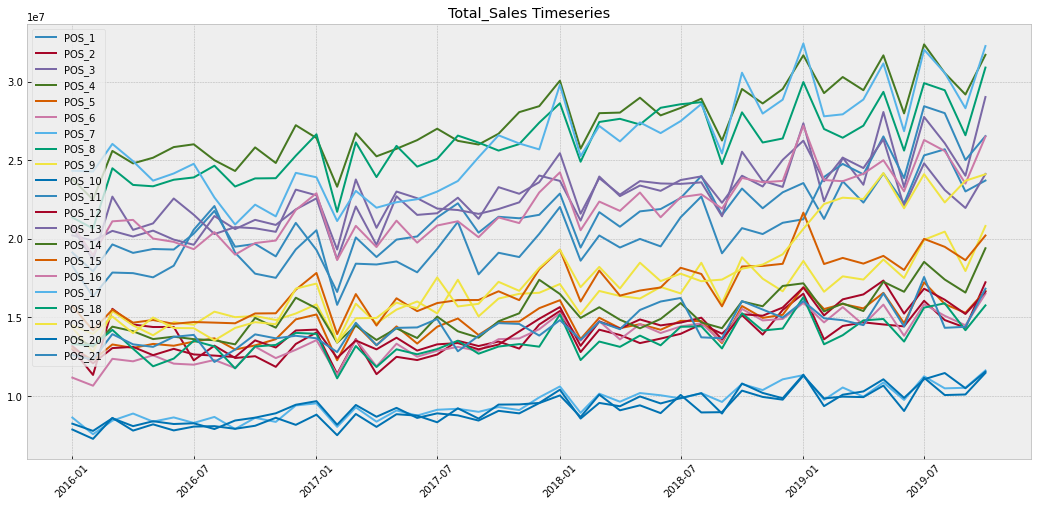

In [64]:
#sns.set_style("whitegrid")
plt.figure(figsize=(18,8))
# Draw the boxplots
POS = range(1,22)
for pos_id in POS:
    data = preprocessing(df,product_id=str(pos_id))
    data = data.iloc[:-2]  
    plt.plot(data,label="POS_" + str(pos_id))  

plt.title('Total_Sales Timeseries')
plt.xticks(rotation=45)
plt.legend()